# Importing the Required Libraries

In [1]:
!pip install -q librosa resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.0 MB/s eta 0:00:0000:0100:01


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, 
    BatchNormalization, GlobalAveragePooling2D,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

2025-06-24 09:25:47.839392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750757148.033186      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750757148.091119      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Structuring the Dataset

In [3]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
intensity_map = {
    '01': 'normal',
    '02': 'strong'
}
statement_map = {
    '01': 'Kids are talking by the door',
    '02': 'Dogs are sitting by the door'
}
repetition_map = {
    '01': '1st',
    '02': '2nd'
}

ROOT_SPEECH = "/kaggle/input/emotion-classification-mars/Audio_Speech_Actors_01-24"
ROOT_SONG = "/kaggle/input/emotion-classification-mars/Audio_Song_Actors_01-24"

In [4]:
def parse_filename(filepath, source):
    filename = os.path.basename(filepath)
    parts = filename.split('.')[0].split('-')
    
    if parts[0] != '03':
        return None  # Not audio-only
    vocal_channel = parts[1]
    emotion = parts[2]
    intensity = parts[3]
    statement = parts[4]
    repetition = parts[5]
    actor_id = int(parts[6])
    gender = 'male' if actor_id % 2 else 'female'
    emotion_name = emotion_map.get(emotion)
    modality = 'speech' if vocal_channel == '01' else 'song'
    
    return {
        'filepath': filepath,
        'emotion_label': emotion,
        'emotion_name': emotion_name,
        'intensity': intensity_map.get(intensity),
        'statement': statement_map.get(statement),
        'repetition': repetition_map.get(repetition),
        'gender': gender,
        'modality': modality
    }

In [5]:
data = []
for root_dir, source in [(ROOT_SPEECH, 'speech'), (ROOT_SONG, 'song')]:
    for actor_folder in os.listdir(root_dir):
        actor_path = os.path.join(root_dir, actor_folder)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    full_path = os.path.join(actor_path, file)
                    parsed = parse_filename(full_path, source)
                    if parsed:
                        data.append(parsed)

In [6]:
df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")
print(f"Emotion distribution:\n{df['emotion_name'].value_counts()}")

Total samples: 2452
Emotion distribution:
emotion_name
fearful      376
happy        376
calm         376
sad          376
angry        376
surprised    192
disgust      192
neutral      188
Name: count, dtype: int64


In [7]:
df.head()

,filepath,emotion_label,emotion_name,intensity,statement,repetition,gender,modality
0,/kaggle/input/emotion-classification-mars/Audi...,08,surprised,normal,Kids are talking by the door,1st,female,speech
1,/kaggle/input/emotion-classification-mars/Audi...,01,neutral,normal,Kids are talking by the door,1st,female,speech
2,/kaggle/input/emotion-classification-mars/Audi...,07,disgust,strong,Kids are talking by the door,2nd,female,speech
3,/kaggle/input/emotion-classification-mars/Audi...,07,disgust,normal,Kids are talking by the door,2nd,female,speech
4,/kaggle/input/emotion-classification-mars/Audi...,01,neutral,normal,Dogs are sitting by the door,1st,female,speech


#  Feature Extraction using MFCC

In [ ]:
# Enhanced feature extraction with multiple features
def extract_enhanced_features(file_path, max_pad_len=174):
    
        audio, sample_rate = librosa.load(file_path, sr=22050, res_type='kaiser_fast')
        
        if np.max(np.abs(audio)) > 0:
            audio = audio / np.max(np.abs(audio))
        
        # Extract multiple features with error handling
        features_list = []
        
        # 1. MFCC features
        try:
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512)
            features_list.append(mfcc)
        except:
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
            features_list.append(mfcc)
        
        # 2. Chroma features
        try:
            chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, hop_length=512)
            features_list.append(chroma)
        except:
            try:
                chroma = librosa.feature.chromagram(y=audio, sr=sample_rate)
                features_list.append(chroma)
            except:
                pass
        
        # Spectral contrast
        try:
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, hop_length=512)
            features_list.append(spectral_contrast)
        except:
            pass
        
        # Zero crossing rate
        try:
            zcr = librosa.feature.zero_crossing_rate(audio, hop_length=512)
            features_list.append(zcr)
        except:
            pass
        
        # Spectral rolloff
        try:
            spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, hop_length=512)
            features_list.append(spectral_rolloff)
        except:
            pass
        
        # Spectral centroid
        try:
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate, hop_length=512)
            features_list.append(spectral_centroid)
        except:
            pass
        
        # RMS Energy
        try:
            rms = librosa.feature.rms(y=audio, hop_length=512)
            features_list.append(rms)
        except:
            pass
        
        # Spectral bandwidth
        try:
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate, hop_length=512)
            features_list.append(spectral_bandwidth)
        except:
            pass
        
        # Mel-frequency spectral coefficients 
        try:
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=13, hop_length=512)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            features_list.append(mel_spec_db)
        except:
            pass
        
        # Combine all available features
        if len(features_list) > 0:
            
            min_frames = min([feat.shape[1] for feat in features_list])
            
            features_list = [feat[:, :min_frames] for feat in features_list]
            
            features = np.vstack(features_list)
        else:
            features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        pad_width = max_pad_len - features.shape[1]
        if pad_width > 0:
            features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            features = features[:, :max_pad_len]
            
        return features

In [21]:
print("Extracting enhanced features...")
X, y = [], []
failed_files = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_enhanced_features(row["filepath"])
    if features is not None:
        X.append(features)
        y.append(row["emotion_name"])
    else:
        failed_files.append(row["filepath"])

Extracting enhanced features...


100%|██████████| 2452/2452 [04:36<00:00,  8.87it/s]


In [22]:
X = np.array(X)
y = np.array(y)

print(f"Feature shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Feature shape: (2452, 77, 174)
Labels shape: (2452,)


In [25]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {le.classes_}")

Number of classes: 8
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [26]:
# Reshape for CNN input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (1961, 77, 174, 1)
Validation set shape: (491, 77, 174, 1)


In [27]:
def augment_data(X_train, y_train, augmentation_factor=2):
    """Apply data augmentation techniques to training data only"""
    augmented_X = []
    augmented_y = []
    
    for i in range(len(X_train)):
        # Original sample
        augmented_X.append(X_train[i])
        augmented_y.append(y_train[i])
        
        # Apply augmentations
        for _ in range(augmentation_factor):
            # Time shifting
            shift = np.random.randint(-10, 10)
            shifted = np.roll(X_train[i], shift, axis=1)
            augmented_X.append(shifted)
            augmented_y.append(y_train[i])
            
            # Add noise
            noise_factor = 0.005
            noise = np.random.normal(0, noise_factor, X_train[i].shape)
            noisy = X_train[i] + noise
            augmented_X.append(noisy)
            augmented_y.append(y_train[i])
    
    return np.array(augmented_X), np.array(augmented_y)

In [28]:
print("Applying data augmentation to training data...")
X_train_aug, y_train_aug = augment_data(X_train, y_train, augmentation_factor=1)
print(f"Augmented training set shape: {X_train_aug.shape}")

Applying data augmentation to training data...
Augmented training set shape: (5883, 77, 174, 1)


In [ ]:
def create_improved_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    
    # First CNN block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Second CNN block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Third CNN block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Global Average Pooling to reduce parameters
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers with regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # Output layer
    out = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    return model

In [90]:
# Create and compile model
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = create_improved_model(input_shape, num_classes)

In [91]:
# Use a lower learning rate with the Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 77, 174, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 77, 174, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 77, 174, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 77, 174, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 38, 87, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 38, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 38, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 38, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 19, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 19, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 19, 43, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 19, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 9, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 355,816 (1.36 MB)

 Trainable params: 354,600 (1.35 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [92]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        "best_emotion_model.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [93]:
# Train the model
print("Training the model...")
history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16, 
    callbacks=callbacks,
    verbose=1
)

Training the model...
Epoch 1/100
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2621 - loss: 2.2597
Epoch 1: val_accuracy improved from -inf to 0.15275, saving model to best_emotion_model.h5
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.2623 - loss: 2.2591 - val_accuracy: 0.1527 - val_loss: 3.1670 - learning_rate: 0.0010
Epoch 2/100
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4303 - loss: 1.7005
Epoch 2: val_accuracy improved from 0.15275 to 0.19348, saving model to best_emotion_model.h5
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4305 - loss: 1.7000 - val_accuracy: 0.1935 - val_loss: 6.5159 - learning_rate: 0.0010
Epoch 3/100
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5244 - loss: 1.4697
Epoch 3: val_accuracy improved from 0.19348 to 0.21589, saving model to best_emotion_model.h5
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5247 - loss: 1.4692 - val_accuracy: 0.2159 - val_loss: 7.9788 - learning_rate: 0.0010
Epoch 4/

In [94]:
# Evaluate the model
print("\nEvaluating the model...")
y_pred = model.predict(X_val).argmax(axis=1)
accuracy = np.mean(y_pred == y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
print(classification_report(y_val, y_pred, target_names=le.classes_))


Evaluating the model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Validation Accuracy: 0.8880

Classification Report:
              precision    recall  f1-score   support

       angry       0.98      0.87      0.92        75
        calm       0.93      0.91      0.92        75
     disgust       0.92      0.87      0.89        39
     fearful       0.88      0.92      0.90        75
       happy       0.87      0.89      0.88        75
     neutral       0.76      0.89      0.82        38
         sad       0.84      0.83      0.83        75
   surprised       0.90      0.95      0.92        39

    accuracy                           0.89       491
   macro avg       0.89      0.89      0.89       491
weighted avg       0.89      0.89      0.89       491




Generating Confusion Matrix...


<Figure size 1000x800 with 0 Axes>

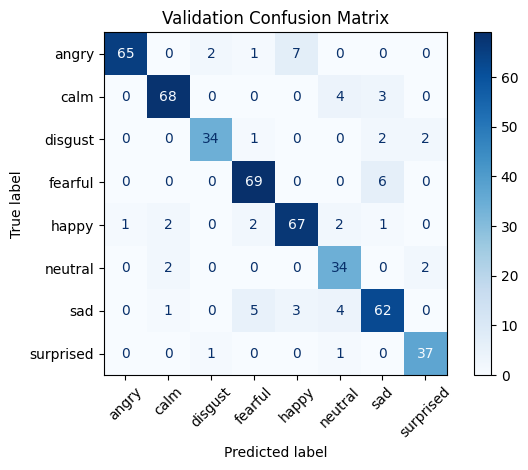

In [ ]:
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

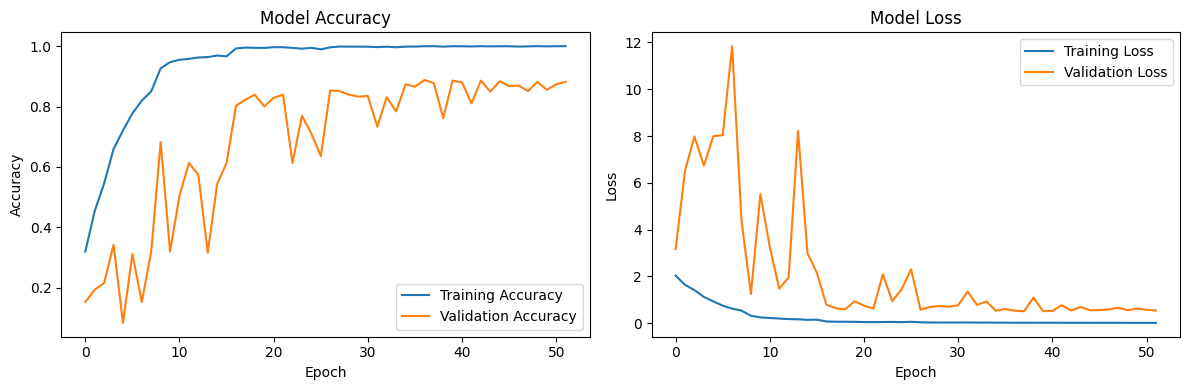

In [97]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [98]:
# Save the model and label encoder
model.save("final_emotion_model.h5")
import joblib
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']